C:\Users\Programmieren\AppData\Local\Temp\ipykernel_18124\844994142.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  psis[0]=torch.tensor(env.psi).detach().numpy()
C:\Users\Programmieren\AppData\Local\Temp\ipykernel_18124\844994142.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  reward_=torch.tensor((reward_),dtype=torch.float)


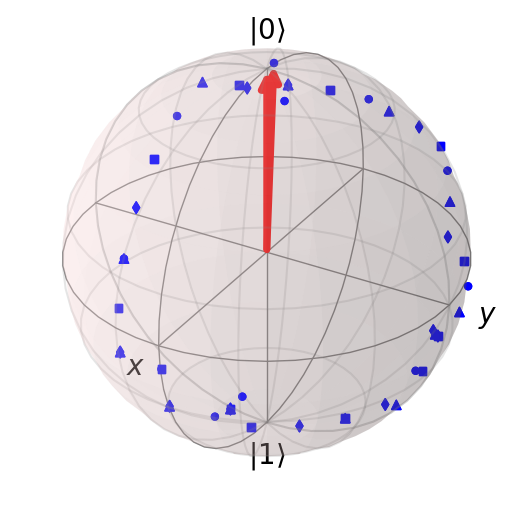

In [10]:
import torch

# animation
import numpy as np
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from qiskit.visualization.bloch import Bloch

identity = np.array([[1.0, 0.0], [0.0, +1.0]], dtype=complex)
sigma_x = np.array([[0.0, 1.0], [1.0, 0.0]], dtype=complex)
sigma_y = np.array([[0.0, -1.0j], [1.0j, 0.0]], dtype=complex)
sigma_z = np.array([[1.0, 0.0], [0.0, -1.0]], dtype=complex)

class QubitEnv:

    def __init__(self,seed,n_timesteps,error=10e-6):
        self.err=error
        self.delta_t=2*np.pi/n_timesteps
        self.n_actions=4
        self.action_space = []
        for generator in [identity, sigma_x, sigma_y, sigma_z]:
            self.action_space.append(torch.linalg.matrix_exp(-1j * self.delta_t * torch.from_numpy(generator)))
        self.actions=[0,1,2,3]
        torch.manual_seed(seed)

        self.state=self.init_state(random=True)
        self.psi=self.state_to_psi(self.state)

        self.target_psi=torch.tensor([1,0],dtype=torch.cdouble)
        self.target_state=self.psi_to_state(self.target_psi)



    def step(self,action,nstep):
        self.psi=torch.matmul(self.action_space[action],self.psi)
        self.state=self.psi_to_state(self.psi)
        reward_=torch.abs(torch.dot(self.psi,self.target_psi))**2
        reward_=torch.tensor((reward_),dtype=torch.float)
        done=False

        if torch.abs(1-reward_)<self.err or nstep*self.delta_t>=2*np.pi:
            done=True
        return self.state,reward_,done

    def init_state(self, random=True):
        if random:
            theta = np.pi*torch.rand(1)
            phi = 2*np.pi*torch.rand(1)
        else:
            # start from south pole of Bloch sphere
            theta = np.pi
            phi = 0.0

        self.state = torch.tensor([theta, phi], dtype=torch.double)
        self.psi = self.state_to_psi(self.state)
        return self.state

    def state_to_psi(self,s):
        """Take as input the RL state s, and return the quantum state |psi>"""
        theta, phi = s
        psi = torch.tensor([torch.cos(0.5 * theta), torch.exp(1j * phi) * torch.sin(0.5 * theta)],dtype=torch.cdouble)
        return psi

    def psi_to_state(self,psi):
        """
        Take as input the RL state s, and return the quantum state |psi>
        """
        # take away unphysical global phase
        alpha = torch.angle(psi[0])
        psi_new = torch.exp(-1j * alpha) * psi

        # find Bloch sphere angles
        theta = 2.0 * torch.arccos(psi_new[0]).real
        phi = torch.angle(psi_new[1])

        return torch.tensor([theta, phi],dtype=torch.double)
















# count=50
# env = QubitEnv(0,count)
#
# env.init_state(True)
# psis=np.zeros((count,2),dtype=complex)
# psis[0]=torch.tensor(env.psi).detach().numpy()
# for i in range(1,count):
#     action=np.random.choice([0,1,2,3])
#     state, reward, done=env.step(action=action,nstep=i)
#     psis[i]=env.psi.detach().numpy()
#     # print(psi,psis[i],np.abs(psis[i].conj().dot(psis[i])**2))
#     if done:
#         break
# # Calculation stuff for plotting
# s1 = np.array([[0, 1], [1, 0]], dtype=complex)
# s2 = np.array([[0, -1j], [1j, 0]], dtype=complex)
# s3 = np.array([[1, 0], [0, -1]], dtype=complex)
#
#
# def calc_location(state):
#     # We assume the state is given as an array.
#     npstate = np.array(state, dtype=complex)
#     x = np.matmul(np.conjugate(npstate), np.matmul(s1, np.transpose(npstate))).real
#     y = np.matmul(np.conjugate(npstate), np.matmul(s2, np.transpose(npstate))).real
#     z = np.matmul(np.conjugate(npstate), np.matmul(s3, np.transpose(npstate))).real
#     return [x, y, z]
#
# fig = plt.figure(figsize=(5, 5))
# ax = Axes3D(fig, auto_add_to_figure=False)
# fig.add_axes(ax)
# ax.set_xlim(-10, 10)
# ax.set_ylim(-10, 10)
# sphere = Bloch(axes=ax)
#
# def animate(i):
#     sphere.clear()
#     sphere.add_vectors(calc_location(env.target_psi))
#     sphere.add_vectors(calc_location(psis[i]))
#     if i>0:
#         # x,y,z=zip(calc_location(psis[i]),calc_location(psis[i-1]))
#         # ax.plot3D(x,y,z,'ro--')
#         for j in range(i):
#             sphere.add_points(calc_location(psis[j]))
#     sphere.make_sphere()
#     return ax
#
# def init():
#     sphere.vector_color = ['r']
#     sphere.point_color=['b']
#     return ax
#
#
#
# ani = animation.FuncAnimation(
#     fig,
#     animate,
#     np.arange(len(psis)),
#     init_func=init,
#     blit=False,
#     repeat=False
# )
# HTML(ani.to_jshtml())